# Perfect Beer Bar Location in Paris

In this notebook the analysis of data is performed to make prediction of a perfect location to set up a bar in Paris. This notebook consists of several parts.

## Table of Contents

1. <a href="#item1"> <em>Import libraries and data</em> </a>
2. <a href="#item2"> <em>Data preparation</em> </a>
3. <a href="#item3"> <em>First data analysis and choosing the appropriate district</em> </a> 
4. <a href="#item3"> <em>Final data analysis for best bar location</em> </a>  

### 1. *Import libraries and data*

In [84]:
# import the libraries

# to download the data
import urllib.request
# to work with dataframes
import pandas as pd
# to work with numerical data
import numpy as np
# to plot the map
import folium
from folium.plugins import MarkerCluster
# to perform clustering
from sklearn.cluster import KMeans
# library to handle requests
import requests 
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [99]:
### download data for the population within districts
url_population = 'https://opendata.arcgis.com/datasets/7104e166a3af481d866d47beb96c0e36_0.csv?outSR=%7B%22latestWkid%22%3A2154%2C%22wkid%22%3A102110%7D'
urllib.request.urlretrieve(url_population, 'arr_population.csv')

### download data to extract number of employees
url_employee = 'https://opendata.arcgis.com/datasets/37834644c7534e3c9f25c4a73c08b2ed_0.csv?outSR=%7B%22latestWkid%22%3A2154%2C%22wkid%22%3A102110%7D'
urllib.request.urlretrieve(url_employee, 'employee.csv')

### download data to know number of cultural places in districts
url_culture='https://opendata.arcgis.com/datasets/8aa9dd03a284497c86c02ba3ecac0cdd_0.csv?outSR=%7B%22latestWkid%22%3A2154%2C%22wkid%22%3A102110%7D'
urllib.request.urlretrieve(url_culture, 'cultural_places.csv')

('cultural_places.csv', <http.client.HTTPMessage at 0x7f6c71d32438>)

### 2. *Data preparation*

#### 2.1 Prepare the data on population in districts

In [3]:
# load the data and show it
df_pop=pd.read_csv("arr_population.csv")
df_pop.head()

,OBJECTID,N_SQ_AR,C_AR,C_ARINSEE,L_AR,L_AROFF,N_SQ_CO,NB_POP99,NB_POP08,NB_POP10,POU_E99_10,SHAPE_Length,SHAPE_Area
0,1,750000019,19,75119,19ème,Buttes-Chaumont,750001537,172587,184909,186652,8.149513,11252.943198,6.792651e+06
1,2,750000005,5,75105,5ème,Panthéon,750001537,58841,62143,60938,3.563842,6238.823371,2.539375e+06
2,3,750000020,20,75120,20ème,Ménilmontant,750001537,183093,195083,196880,7.530053,10704.483624,5.983446e+06
3,4,750000001,1,75101,1er,Louvre,750001537,16895,17440,17308,2.444510,6054.680831,1.824613e+06
4,5,750000010,10,75110,10ème,Entrepôt,750001537,89685,94321,95394,6.365613,6739.168204,2.891739e+06


In [4]:
# we need to extract the district number 'C_AR', its identifier from the database 'C_ARINSEE' and population 'NB_POP10'
# we also sort the data on identifier
df_pop = df_pop.loc[:, df_pop.columns.intersection(['C_AR','C_ARINSEE','NB_POP10'])].sort_values(by=['C_ARINSEE'])
# reset the row numbers
df_pop.reset_index(drop=True, inplace=True)
# replace the column name 'C_AR' to 'Number','NB_POP10' to 'Population'
df_pop.rename(columns={"C_AR": "Number","NB_POP10": "Population"},inplace = True)
# show the column
df_pop.head()

,Number,C_ARINSEE,Population
0,1,75101,17308
1,2,75102,23009
2,3,75103,35652
3,4,75104,28012
4,5,75105,60938


#### 2.2 Prepare the data on number of employees in districts 

In [5]:
# load the data and show it
df_empl=pd.read_csv("employee.csv")
df_empl.head()

,OBJECTID,N_SQ_IR,C_CAINSEE,N_QU,C_IR,C_TYPEIR,L_IR,M2_IP,M2_POP,M2_EMP,...,C12_POP15P_CS5,C12_POP15P_CS6,C12_POP15P_CS,CS3_CS56,P12_POP_ETR,TX12_POP_ETR,P12_POP_IMM,TX12_POP_IMM,SHAPE_Length,SHAPE_Area
0,1,750004651,75112,48.0,751124806,H,Quinze Vingts 6,35663.273678,31569.299621,32907.156379,...,216.698960,55.465073,1441.390537,3.031327,271.076525,11.628482,326.122252,13.989801,1074.403007,54817.007288
1,2,750004611,75112,48.0,751124807,H,Quinze Vingts 7,63724.185571,57681.480525,59621.609239,...,407.954128,107.881520,2065.037695,1.832804,361.338039,11.116247,505.601883,15.554397,1621.888235,91619.673610
2,3,750004683,75112,48.0,751124808,H,Quinze Vingts 8,36888.617306,32368.082580,32368.082580,...,223.437490,65.808063,1351.344232,2.677041,262.572809,11.217757,378.304109,16.162083,1297.312428,64396.187009
3,4,750004647,75112,48.0,751124809,H,Quinze Vingts 9,41811.631196,34551.616325,41092.399164,...,286.182600,124.914166,1623.895813,1.705357,391.649474,14.698936,513.750041,19.281473,1263.588885,60185.717211
4,5,750004652,75112,48.0,751124810,H,Quinze Vingts 10,51442.988290,47254.592209,50562.351004,...,256.602636,106.839679,1651.946137,2.192297,505.074201,15.886250,649.501286,20.428958,1254.206414,71374.621050


In [6]:
# we extract the district identifier 'C_CAINSEE' and the number of employees from 'C12_POP15P_CS5'
df_empl = df_empl.loc[:, df_empl.columns.intersection(['C_CAINSEE','C12_POP15P_CS5'])]
# show the data
df_empl.head()

,C_CAINSEE,C12_POP15P_CS5
0,75112,216.698960
1,75112,407.954128
2,75112,223.437490
3,75112,286.182600
4,75112,256.602636


In [7]:
# we need to get the data only inside the districts of interest, that's why we group the data and show the sum within districts
df_empl=df_empl[df_empl['C_CAINSEE'].astype(str).str.contains("751")].groupby(['C_CAINSEE']).sum().astype(int)
# update the indexing
df_empl.reset_index(inplace=True)
# show the data
df_empl.head()

,C_CAINSEE,C12_POP15P_CS5
0,75101,1647
1,75102,2215
2,75103,3288
3,75104,2629
4,75105,4571


In [8]:
# replace the column name 'C_CAINSEE' to 'C_ARINSEE','C12_POP15P_CS5' to 'Employees' for later merging the dataframes
df_empl.rename(columns={"C_CAINSEE": "C_ARINSEE","C12_POP15P_CS5": "Employees"},inplace = True)
# show the data
df_empl.head()

,C_ARINSEE,Employees
0,75101,1647
1,75102,2215
2,75103,3288
3,75104,2629
4,75105,4571


#### 2.3 Prepare the data on number of cultural places in districts

In [9]:
# load the data and show it
df_cult=pd.read_csv("cultural_places.csv")
df_cult.head()

,X,Y,OBJECTID,NOM_LIEU,DEP,COMMUNE,CODE_INSEE,CODE_POSTAL,RAYONNEMENT,GPE_800M,...,C_SUF3,C_DESI,C_LIAISON,L_VOIE,N_SQ_EP,C_NIV1,C_NIV2,C_NIV3,COORD_X,COORD_Y
0,653770.9707,6.863828e+06,2001,Musée des Moulages Dermatologiques,75,Paris 10e Arrondissement,75110,75010.0,3.0,Non,...,NaN,AV,NaN,CLAUDE VELLEFAUX,752003607,13,133,13311,653770.9706,6.863828e+06
1,649586.6555,6.862236e+06,2002,Musée des Plans-Reliefs de Paris,75,Paris 7e Arrondissement,75107,75007.0,2.0,Non,...,,RUE,DE,GRENELLE,752003585,13,133,13311,649586.6554,6.862236e+06
2,642338.4269,6.863770e+06,2003,Musée des Transmissions et de colombophilie mi...,92,Suresnes,92073,92150.0,3.0,Non,...,NaN,RUE,DU,COLONEL HUBERT DELESTREE,923002813,13,133,13311,642338.4268,6.863770e+06
3,671072.2973,6.864174e+06,2004,Musée des Transports Urbains,77,Chelles,77108,77500.0,3.0,Non,...,NaN,RUE,NaN,GABRIEL DE MORTILLET,770000096,13,133,13311,671072.2972,6.864174e+06
4,649586.6555,6.862236e+06,2005,Musée d'Histoire Contemporaine - Hôtel des Inv...,75,Paris 7e Arrondissement,75107,75007.0,3.0,Non,...,NaN,RUE,NaN,GRENELLE,752003582,13,133,13311,649586.6554,6.862236e+06


In [10]:
# extract the column with identifiers 'CODE_INSEE' and 'CODE_POSTAL'
df_cult=df_cult.loc[:, df_cult.columns.intersection(['CODE_INSEE','CODE_POSTAL'])]
# drop possible NaN values
df_cult.dropna(inplace=True)
# treat the data as integer
df_cult=df_cult.astype(int)
# show the data
df_cult.head()

,CODE_INSEE,CODE_POSTAL
0,75110,75010
1,75107,75007
2,92073,92150
3,77108,77500
4,75107,75007


In [11]:
# extract only those areas which is inside Paris, i.e. postal code is 75001...75020
df_cult = df_cult[df_cult['CODE_POSTAL'].between(75001, 75020)]
# show the dataframe
df_cult.head()

,CODE_INSEE,CODE_POSTAL
0,75110,75010
1,75107,75007
4,75107,75007
8,75101,75001
9,75112,75012


In [12]:
# group the data based on the identifiers and add the number of cultural places in districts
df_cult=df_cult.groupby(['CODE_INSEE','CODE_POSTAL']).CODE_POSTAL.agg('count').to_frame('Cultural Sites').reset_index()
# replace the column name 'C_CAINSEE' to 'C_ARINSEE','CODE_POSTAL' to 'Post Code' for later merging the dataframes
df_cult.rename(columns={"CODE_INSEE": "C_ARINSEE","CODE_POSTAL": "Post Code"},inplace = True)
# show the data
df_cult.head()

,C_ARINSEE,Post Code,Cultural Sites
0,75101,75001,31
1,75102,75002,21
2,75103,75003,47
3,75104,75004,49
4,75105,75005,51


#### 2.4 Prepare the data on rent price in districts

In [13]:
# get the data from https://droit-finances.commentcamarche.com/faq/7409-immobilier-a-paris-prix-au-m2-des-arrondissements
# make a dataframe manually

# the rent is given in euros/m^2
d_rent = {'Post Code': range(75001, 75021), 'Cost': [12660,11370,11340,12750,11770,13010,12340,10560,10150,8870,9580,8720,8610,9330,9350,10070,9600,8890,7800,8240]}
df_rent=pd.DataFrame(data=d_rent)
# show the data
df_rent.head()

,Post Code,Cost
0,75001,12660
1,75002,11370
2,75003,11340
3,75004,12750
4,75005,11770


#### 2.5 Merge the data for the final dataframe

In [14]:
### merge tables on population and employees 
df1=pd.merge(df_pop, df_empl, on="C_ARINSEE")
### merge tables on cultural sites and rent price
df2=pd.merge(df_cult, df_rent, on="Post Code")
### final table
df=pd.merge(df1,df2, on="C_ARINSEE")
df.head()

,Number,C_ARINSEE,Population,Employees,Post Code,Cultural Sites,Cost
0,1,75101,17308,1647,75001,31,12660
1,2,75102,23009,2215,75002,21,11370
2,3,75103,35652,3288,75003,47,11340
3,4,75104,28012,2629,75004,49,12750
4,5,75105,60938,4571,75005,51,11770


In [15]:
# drop the unnecessary identifier columns
df.drop(columns='C_ARINSEE',inplace = True)
# change the order of the columns
df = df[['Number', 'Post Code', 'Population', 'Cultural Sites', 'Employees','Cost']]
# show the final data frame
df.head()

,Number,Post Code,Population,Cultural Sites,Employees,Cost
0,1,75001,17308,31,1647,12660
1,2,75002,23009,21,2215,11370
2,3,75003,35652,47,3288,11340
3,4,75004,28012,49,2629,12750
4,5,75005,60938,51,4571,11770


### 3. *First data analysis and choosing the appropriate district*

#### 3.1 Data visualisation

First of all we need to visualise the data to see the distribution of different features of the districts. It is better to use diagrams for this purposes.

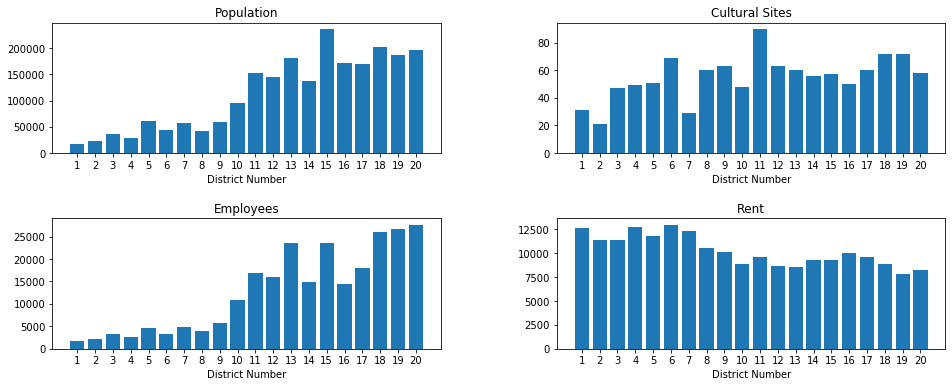

In [48]:
# We will use bar plots to see the distribution of different features in district
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# prepare the bar plot for population
axs[0, 0].bar(df['Number'], df['Population'])
axs[0, 0].set_title('Population')
axs[0, 0].set_xlabel('District Number')

# prepare the bar plot for cultural sites
axs[0, 1].bar(df['Number'], df['Cultural Sites'])
axs[0, 1].set_title('Cultural Sites')
axs[0, 1].set_xlabel('District Number')

# prepare the bar plot for number of employees
axs[1, 0].bar(df['Number'], df['Employees'])
axs[1, 0].set_title('Employees')
axs[1, 0].set_xlabel('District Number')

# prepare the bar plot for rent cost
axs[1, 1].bar(df['Number'], df['Cost'])
axs[1, 1].set_title('Rent')
axs[1, 1].set_xlabel('District Number')

plt.setp(axs, xticks=df['Number'], xticklabels=df['Number'])
plt.show()


As one could notice the distribution of features is different between different districts

#### 3.2 Obtain 3 districts for best location of a bar

For this purpose we try to maximize population, number of cultural sites inside district and at the same time we need to minimize the rent price. Therefore, it is enough to take the sum of three features and subtract the cost. This combination will provide a score according to which we can sort the data in ascending order to obtain top 3 districts for a bar.

In [308]:
# create a new column to present the score as a combination of other columns
df['Score']=df['Population']+df['Cultural Sites']+df['Employees']-df['Cost']
# sort the results by score
df.sort_values(by='Score',ascending=False, inplace= True)
# show top 3 results
df.head(3)

,Number,Post Code,Population,Cultural Sites,Employees,Cost,Score
14,15,75015,236715,57,23545,9350,250967
17,18,75018,202685,72,25977,8890,219844
19,20,75020,196880,58,27667,8240,216365


<font size = 4>
    
__`We conclude that districts 15,18 and 20 are potentially better for setting up a bar.`__

### 4. *Final data analysis for best bar location*

In [269]:
CLIENT_ID = 'NYG5NQGL1AOJDRSSNPIZKVUGK2VZTXV1YMEROF1REDGVENHC' # your Foursquare ID
CLIENT_SECRET = 'KZRS3H5EHJCG4G0RJBARFQHWK5TLD2MAN4CZKTKXWC1X4CTN' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 10

In [309]:
search_query = 'Bar'
near_15 ='Paris, France' 
lat_query_15 = 48.840867
lg_query_15 = 2.292800
radius_15 = 100
search_section = 'drinks'

url='https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&near={}&v={}&query={}&section={}&radius={}&limit={}'
url15 =url.format(CLIENT_ID, CLIENT_SECRET,lat_query_15,lg_query_15,near_15,VERSION, search_query,search_section,radius_15,LIMIT)

In [310]:
results = requests.get(url15).json()

In [311]:
# assign relevant part of JSON to venues
venues = results['response']['venues']
# # tranform venues into a dataframe
#df_venues = json_normalize(venues)
#df_venues.head()

In [312]:
df_venues = json_normalize(venues)

In [313]:
results['response']

{'venues': [],
 'geocode': {'what': '',
  'where': 'paris france',
  'feature': {'cc': 'FR',
   'name': 'Paris',
   'displayName': 'Paris',
   'matchedName': 'Paris, France',
   'highlightedName': '<b>Paris</b>, <b>France</b>',
   'woeType': 7,
   'slug': 'paris',
   'id': 'geonameid:2988507',
   'longId': '72057594040916443',
   'geometry': {'center': {'lat': 48.85341, 'lng': 2.3488},
    'bounds': {'ne': {'lat': 49.03356694704047, 'lng': 2.6042489194755207},
     'sw': {'lat': 48.670322030624696, 'lng': 2.1084049608796893}}}},
  'parents': []}}

In [301]:
# get the information of interest
df_venues=df_venues.loc[:, df_venues.columns.intersection(['location.postalCode','name','location.lat','location.lng'])]
# rename the columns
df_venues.rename(columns={"name": "Name","location.lat": "Latitude","location.lng": "Longitude","location.postalCode": "Post Code"},inplace = True)
# show the data
df_venues.head()

,Name,Latitude,Longitude,Post Code
0,Piano Bar,48.852967,2.345922,75005
1,Onze Bar,48.852674,2.345438,75005
2,Le Bo Bar,48.849849,2.349628,NaN
3,Bar Limon,48.852998,2.353356,NaN
4,Le Quasimodo Notre-Dame,48.854366,2.349851,75004


In [302]:
# modify the Post Code column and make it digit

# import the library to find digits in a string
import re

# in a loop, change the values of Post Code to integer
for i,j in enumerate(df_venues['Post Code']):
    val=re.findall(r'\d+',str(df_venues['Post Code'][i]).replace(" ", ""))    
    if val:
        df_venues['Post Code'][i]=int(val[0])
    else:
        df_venues['Post Code'][i]= float('nan')
# drop possible NaN values
df_venues.dropna(inplace=True)
# show the data
df_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Name,Latitude,Longitude,Post Code
0,Piano Bar,48.852967,2.345922,75005
1,Onze Bar,48.852674,2.345438,75005
4,Le Quasimodo Notre-Dame,48.854366,2.349851,75004
5,Île de la Cité,48.854980,2.347003,75004
6,Bardakis,48.852455,2.345032,75005


In [303]:
df_venues.shape

(8, 4)

In [304]:
df_venues.head(10)

,Name,Latitude,Longitude,Post Code
0,Piano Bar,48.852967,2.345922,75005
1,Onze Bar,48.852674,2.345438,75005
4,Le Quasimodo Notre-Dame,48.854366,2.349851,75004
5,Île de la Cité,48.854980,2.347003,75004
6,Bardakis,48.852455,2.345032,75005
7,Chabana's Esmeralda,48.852835,2.345607,75005
8,Le Baryton,48.850382,2.350880,75005
9,La Palmeraie,48.851941,2.346120,75005


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [241]:
df_venues_15=df_venues.loc[df_venues['Post Code'] == 75015]
df_venues_15.head()





,Name,Latitude,Longitude,Post Code


In [242]:
df_venues_18=df_venues.loc[df_venues['Post Code'] == 75018]
df_venues_18.head()

,Name,Latitude,Longitude,Post Code


In [244]:
df_venues_20=df_venues.loc[df_venues['Post Code'] == 75020]
df_venues_20.head()

,Name,Latitude,Longitude,Post Code
